In [45]:
import pandas as pd
import networkx as nx
import pandas as pd
import numpy as np
import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from munkres import Munkres, print_matrix
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_theme()
import sys
import gzip
from collections import Counter

In [43]:
path = r"data\Cisco_22_networks\dir_g22_extra_graph_with_gt\dir_edges\out2021_1_1.txt.gz"


'data\\Cisco_22_networks\\dir_g22_extra_graph_with_gt/'

In [46]:
def read_edges_with_ports_to_stats(edges_file,
                                   wload_to_graph=None,  wload_to_port_info=None,
                                   wload_to_directed_longevity=None):
    if wload_to_graph is None:  # Otherwise, add to existing graph
        wload_to_graph = {}
    if wload_to_port_info is None:  # Otherwise, add to existing graph
        wload_to_port_info = {}
    directed_longevity = defaultdict(Counter)
    port_to_freq = Counter()
    # Assume gzip file.
    with gzip.open(edges_file, mode='rt') as fopen: # open in rt=read-text mode
        for line in fopen:
            if line.startswith('#'): # skip comment lines
                continue
            parts = line.split()
            if len(parts) < 3:
                continue
            wload_id = parts[0]
            v1 = parts[1]  # node1, consumer / client
            v2 = parts[2]
            
            if wload_id not in wload_to_graph:
                wload_to_graph[ wload_id ] = defaultdict(Counter)
            v_to_u = wload_to_graph[wload_id]
            port_info = parts[3]
            ports = port_info.split( ',' )
            stats = wload_to_port_info.get(wload_id, None)
            if stats is None:
                stats = defaultdict(set)
                wload_to_port_info[ wload_id ] = stats

            ports_added = False
            for port_tuple in ports:
                #if 0 and '-' not in port_tuple:
                #    continue
                if 'p' not in port_tuple:
                    continue
                port_part = port_tuple.split('-')[0]
                if port_part == '':
                    continue
                port_to_freq[port_part] += 1
                stats[port_part].add((v1, v2))
                ports_added = True
                directed_longevity[wload_id][(v1, v2, port_part)] = 1
                
            if ports_added:
                v_to_u[v1][v2] += 1
                v_to_u[v2][v1] += 1

In [47]:
read_edges_with_ports_to_stats(path)

PermissionError: [Errno 13] Permission denied: 'data\\Cisco_22_networks\\dir_g22_extra_graph_with_gt/'

In [5]:
path = r"C:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code\data\email-Eu-core-department-labels.txt.gz"
labels = pd.read_csv(path)

In [6]:
data = pd.read_csv(r"C:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code\data\email-Eu-core.txt.gz")
data = data.map(str.split)
series_0 = data.map(lambda x:x[0]).values.flatten()
series_1 = data.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)


df = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1)})
df = df.dropna()

In [7]:
def create_adjacency(df:pd.DataFrame)->np.array:
    m = max(max(df["zero"].value_counts().index), max(df["one"].value_counts().index)) + 1
    A = np.zeros((m,m))
    a,b = df["zero"].to_numpy(dtype=int), df["one"].to_numpy(dtype=int)

    A[a,b] =1
            
    return A


In [8]:
A = create_adjacency(df)
G = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
m = A.shape[0]
ind_i = ind_j = np.arange(0,m)
Id = np.zeros([m,m])


In [10]:
labels = pd.read_csv(r"C:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code\data\email-Eu-core-department-labels.txt.gz")
labels= labels.map(str.split)
series_0 = labels.map(lambda x:x[0]).values.flatten()
series_1 = labels.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)

labels = pd.DataFrame({"node": to_integer(series_0), "community": to_integer(series_1)})
labels = labels.dropna()

In [11]:
def assign_com(comms, node, comm):
    comms[comm].append(node)
    return node, comm

assign_com = np.vectorize(assign_com)

def create_communities(df:pd.DataFrame):
    comms = defaultdict(list)
    nodes = df["node"].to_numpy(dtype = int)
    communities =df["community"].to_numpy(dtype = int)
    
    [assign_com(comms, node,  c) for (node, c) in zip(nodes, communities)]

    return comms

In [12]:
comms = create_communities(labels)

In [13]:
graph_A = nx.from_numpy_array(A)
lv_A = nx.community.louvain_communities(graph_A)


community_lva = []
node_lva = []

for i,set in enumerate(lv_A):
    for n in list(set):
        node_lva.append(n)
        community_lva.append(i)

gen_labels_lva = pd.DataFrame({"node": node_lva, "community":community_lva})
gen_labels_lva = gen_labels_lva.sort_values(by="node")
gen_labels_lva = gen_labels_lva[gen_labels_lva["node"]!=0]
gen_labels_lva


,node,community
501,1,14
0,2,0
1,3,0
2,4,0
3,5,0
...,...,...
825,1000,22
145,1001,0
561,1002,14
380,1003,1


In [14]:
gen_labels_lva["community"].value_counts().mean()
gen_labels_lva["community"].value_counts().std()

72.32992626581499

(Text(0.5, 0, 'Community Size'), Text(0, 0.5, 'Number of communities'))

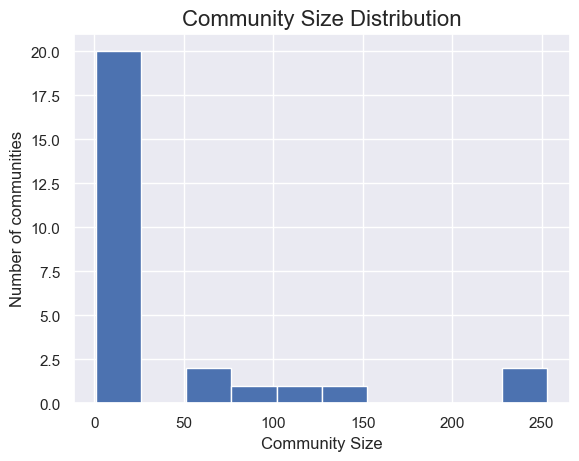

In [30]:
fig, ax = plt.subplots()
ax.hist(gen_labels_lva["community"].value_counts())
plt.title("Community Size Distribution", fontsize=16)
ax.set_xlabel("Community Size"), ax.set_ylabel("Number of communities")